In [1]:
import os
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import joblib

In [2]:
# Define the stock symbols and data directory
stock_symbols = ['AAPL', 'GOOGL', 'MSFT']
data_dir = 'data'

# Function to convert string to datetime
def str_to_datetime(s):
    split = s.split('-')
    year, month, day = int(split[0]), int(split[1]), int(split[2])
    return datetime.datetime(year=year, month=month, day=day)


In [3]:
# Function to create windowed dataframe
def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=3):
    first_date = str_to_datetime(first_date_str)
    last_date  = str_to_datetime(last_date_str)
    target_date = first_date

    dates = []
    X, Y = [], []

    last_time = False
    while True:
        df_subset = dataframe.loc[:target_date].tail(n+1)

        if len(df_subset) != n+1:
            print(f'Error: Window of size {n} is too large for date {target_date}')
            return

        values = df_subset['Close'].to_numpy()
        x, y = values[:-1], values[-1]

        dates.append(target_date)
        X.append(x)
        Y.append(y)

        next_week = dataframe.loc[target_date:target_date+datetime.timedelta(days=7)]
        next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
        next_date_str = next_datetime_str.split('T')[0]
        year_month_day = next_date_str.split('-')
        year, month, day = year_month_day
        next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))

        if last_time:
            break

        target_date = next_date

        if target_date == last_date:
            last_time = True

    ret_df = pd.DataFrame({})
    ret_df['Target Date'] = dates

    X = np.array(X)
    for i in range(0, n):
        X[:, i]
        ret_df[f'Target-{n-i}'] = X[:, i]

    ret_df['Target'] = Y

    return ret_df


In [4]:
# Function to split data into train, validation, and test sets
def split_data(dates, X, y, q_80, q_90):
    dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]
    dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
    dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]
    return dates_train, X_train, y_train, dates_val, X_val, y_val, dates_test, X_test, y_test


In [5]:
# Function to create LSTM model
def create_model(input_shape):
    model = Sequential([
        LSTM(64, input_shape=input_shape, return_sequences=True),
        LSTM(64, return_sequences=False),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

In [6]:
# Function to train the model
def train_model(model, X_train, y_train, X_val, y_val, epochs=50):
    model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs)

# Function to plot predictions
def plot_predictions(dates_train, y_train, train_predictions, dates_val, y_val, val_predictions, dates_test, y_test, test_predictions):
    plt.figure(figsize=(12, 6))
    plt.plot(dates_train, train_predictions)
    plt.plot(dates_train, y_train)
    plt.plot(dates_val, val_predictions)
    plt.plot(dates_val, y_val)
    plt.plot(dates_test, test_predictions)
    plt.plot(dates_test, y_test)
    plt.legend(['Training Predictions', 
                'Training Observations',
                'Validation Predictions', 
                'Validation Observations',
                'Testing Predictions', 
                'Testing Observations'])
    plt.show()


Processing AAPL...
Epoch 1/50


c:\Users\majdt\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - loss: 0.4095 - val_loss: 0.5549
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3214 - val_loss: 0.4008
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2018 - val_loss: 0.1839
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0699 - val_loss: 0.0031
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0124 - val_loss: 0.0139
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0151 - val_loss: 0.0111
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0053 - val_loss: 0.0264
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0067 - val_loss: 0.0088
Epoch 9/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0025 - val_loss: 0.0016
Epoch 10/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0041 - val_loss: 0.0039
Epoch 11/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0025 - val_loss: 0.0077
Epoch 12/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0026 - val_loss: 0.0059
Epoch 13/50
7/7 ━━━━━━━

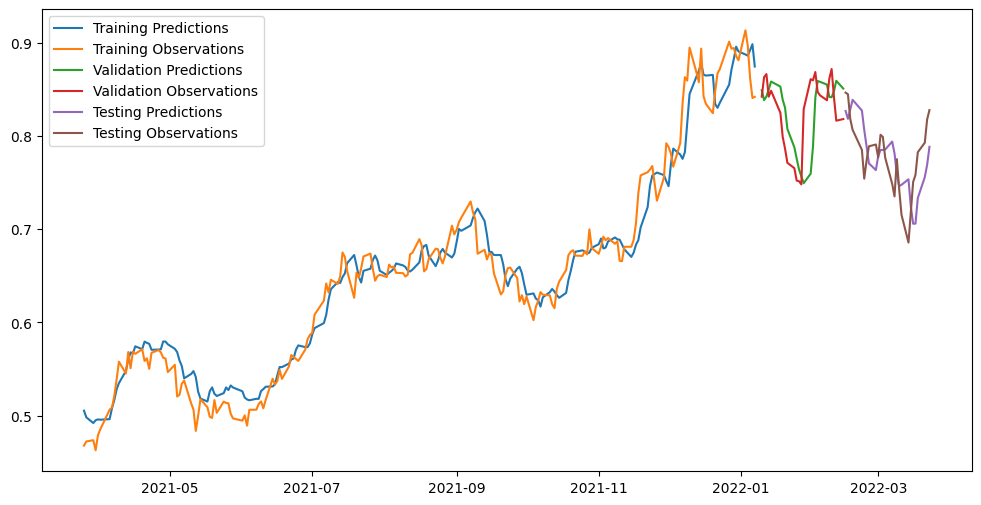

c:\Users\majdt\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Processing GOOGL...
Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - loss: 0.6638 - val_loss: 0.6381
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.5560 - val_loss: 0.4807
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3995 - val_loss: 0.2609
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1883 - val_loss: 0.0280
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0153 - val_loss: 0.0497
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0408 - val_loss: 0.0027
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0038 - val_loss: 0.0134
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0109 - val_loss: 0.0063
Epoch 9/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0043 - val_loss: 0.0026
Epoch 10/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0042 - val_loss: 0.0023
Epoch 11/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0031 - val_loss: 0.0026
Epoch 12/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0027 - val_loss:

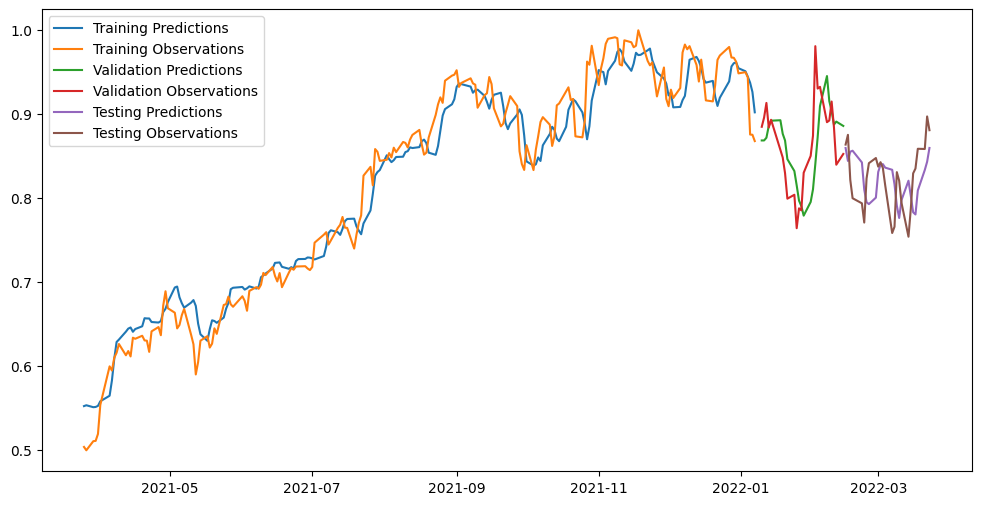

Processing MSFT...
Epoch 1/50


c:\Users\majdt\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 86ms/step - loss: 0.4790 - val_loss: 0.4146
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.3070 - val_loss: 0.1910
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1148 - val_loss: 0.0067
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0120 - val_loss: 0.0365
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0296 - val_loss: 9.5365e-04
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0052 - val_loss: 0.0112
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0096 - val_loss: 0.0035
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0046 - val_loss: 0.0014
Epoch 9/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0050 - val_loss: 0.0010
Epoch 10/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0039 - val_loss: 0.0015
Epoch 11/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0038 - val_loss: 0.0013
Epoch 12/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0035 - val_loss: 9.7015e-04
Epoch 13/50
7/7

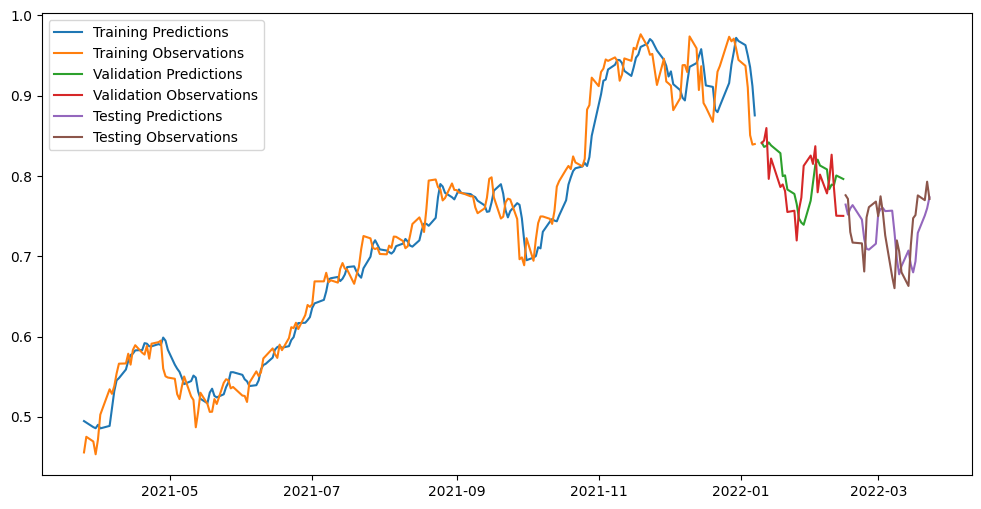

In [7]:
# Process each stock symbol
for symbol in stock_symbols:
    print(f'Processing {symbol}...')
    file_path = os.path.join(data_dir, f'{symbol}_data.csv')
    df = pd.read_csv(file_path)
    
    # Data processing
    df = df[['Date', 'Close']]
    df['Date'] = df['Date'].apply(str_to_datetime)
    df.index = df.pop('Date')

    # Scaling data
    scaler = MinMaxScaler()
    df['Close'] = scaler.fit_transform(df[['Close']].values)  # Fit scaler without feature names

    # Save the scaler
    joblib.dump(scaler, os.path.join('models', f'{symbol}_scaler.pkl'))

    # Create windowed dataframe
    windowed_df = df_to_windowed_df(df, '2021-03-25', '2022-03-23', n=3)
    dates, X, y = windowed_df['Target Date'], windowed_df.iloc[:, 1:-1].values, windowed_df['Target'].values

    # Split the data
    q_80 = int(len(dates) * 0.8)
    q_90 = int(len(dates) * 0.9)
    dates_train, X_train, y_train, dates_val, X_val, y_val, dates_test, X_test, y_test = split_data(dates, X, y, q_80, q_90)

    # Reshape the data to have three dimensions
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

    # Create and train the model
    model = create_model(X_train.shape[1:])
    train_model(model, X_train, y_train, X_val, y_val)

    # Get predictions
    train_predictions = model.predict(X_train).flatten()
    val_predictions = model.predict(X_val).flatten()
    test_predictions = model.predict(X_test).flatten()

    # Plot predictions
    plot_predictions(dates_train, y_train, train_predictions, dates_val, y_val, val_predictions, dates_test, y_test, test_predictions)
    
    # Save the model
    model.save(os.path.join('models', f'{symbol}_lstm_model.h5'))

Processing AAPL...
Epoch 1/50


c:\Users\majdt\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step - loss: 0.3867 - val_loss: 0.4660
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2535 - val_loss: 0.2197
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0888 - val_loss: 0.0096
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0093 - val_loss: 0.0221
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0217 - val_loss: 0.0059
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0040 - val_loss: 0.0250
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0080 - val_loss: 0.0101
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0029 - val_loss: 0.0017
Epoch 9/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0033 - val_loss: 0.0028
Epoch 10/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0025 - val_loss: 0.0070
Epoch 11/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0021 - val_loss: 0.0062
Epoch 12/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0020 - val_loss: 0.0029
Epoch 13/50
7/7 ━━━━━━━

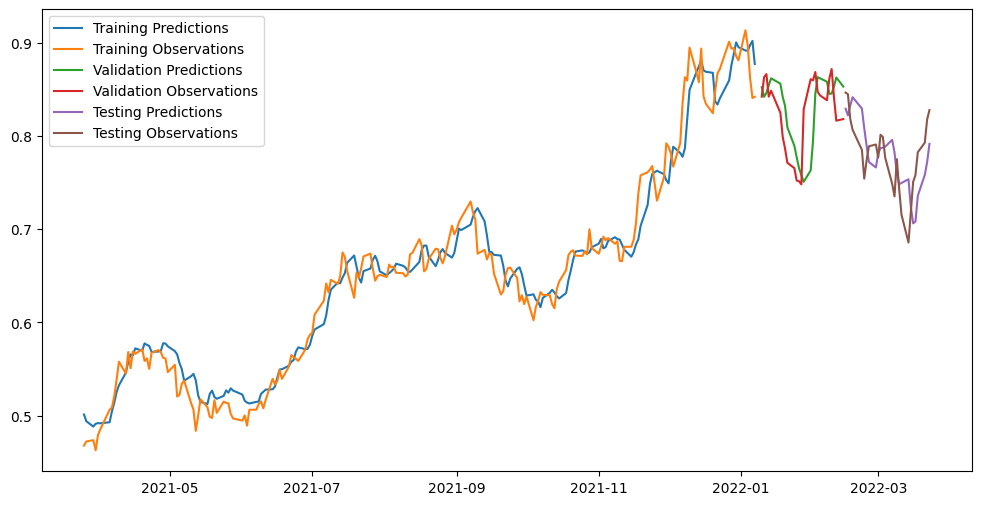

c:\Users\majdt\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Processing GOOGL...
Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - loss: 0.6842 - val_loss: 0.6380
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.5606 - val_loss: 0.4536
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3671 - val_loss: 0.2106
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1326 - val_loss: 0.0062
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0111 - val_loss: 0.0353
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0230 - val_loss: 0.0048
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0077 - val_loss: 0.0114
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0065 - val_loss: 0.0022
Epoch 9/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0039 - val_loss: 0.0025
Epoch 10/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0029 - val_loss: 0.0030
Epoch 11/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0030 - val_loss: 0.0022
Epoch 12/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0023 - val_loss:

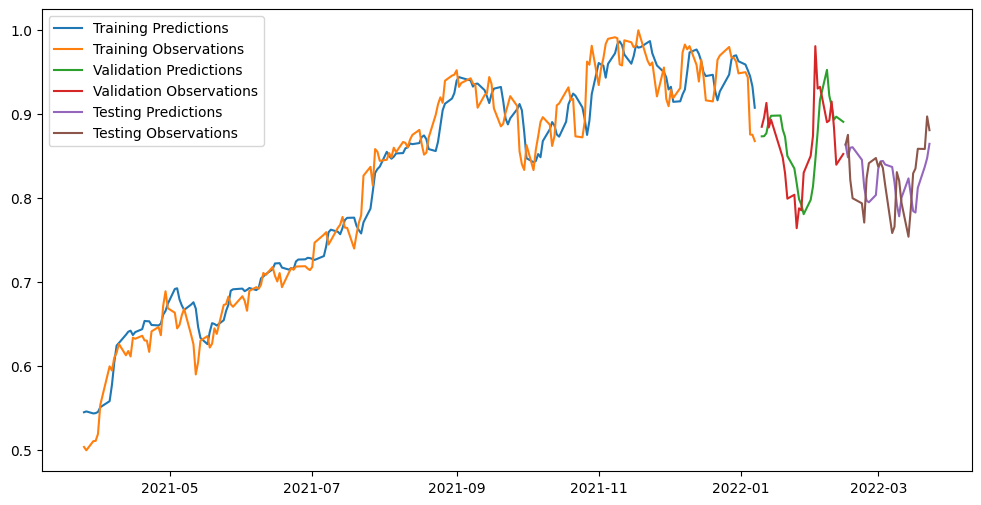

c:\Users\majdt\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Processing MSFT...
Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - loss: 0.5397 - val_loss: 0.4834
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3777 - val_loss: 0.2784
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1941 - val_loss: 0.0464
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0209 - val_loss: 0.0377
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0369 - val_loss: 0.0023
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0057 - val_loss: 0.0126
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0120 - val_loss: 0.0059
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0055 - val_loss: 0.0015
Epoch 9/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0053 - val_loss: 0.0011
Epoch 10/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0045 - val_loss: 0.0022
Epoch 11/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0041 - val_loss: 0.0012
Epoch 12/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0036 - val_loss

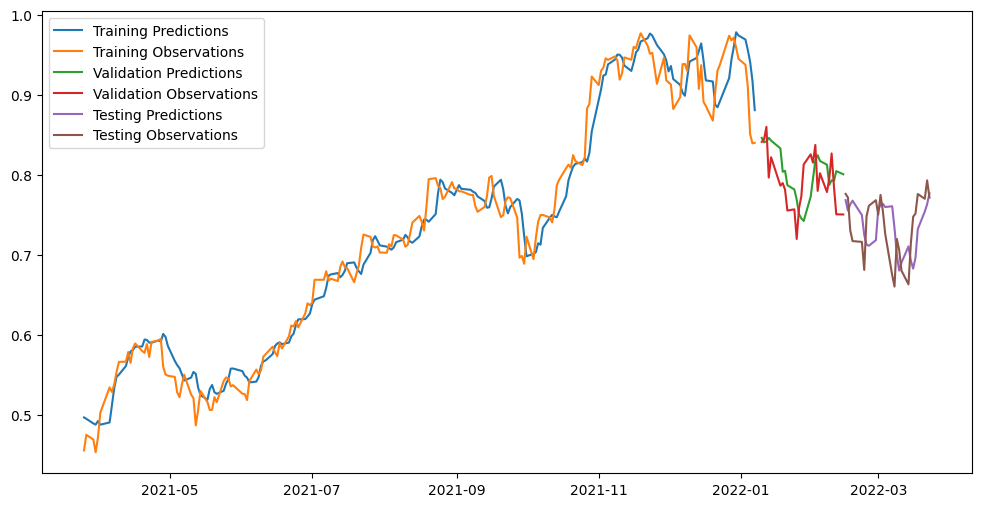

In [13]:
import os
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import joblib

# Define the stock symbols and data directory
stock_symbols = ['AAPL', 'GOOGL', 'MSFT']
data_dir = 'data'

# Function to convert string to datetime
def str_to_datetime(s):
    split = s.split('-')
    year, month, day = int(split[0]), int(split[1]), int(split[2])
    return datetime.datetime(year=year, month=month, day=day)

# Function to create windowed dataframe
def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=3):
    first_date = str_to_datetime(first_date_str)
    last_date  = str_to_datetime(last_date_str)
    target_date = first_date

    dates = []
    X, Y = [], []

    last_time = False
    while True:
        df_subset = dataframe.loc[:target_date].tail(n+1)

        if len(df_subset) != n+1:
            print(f'Error: Window of size {n} is too large for date {target_date}')
            return

        values = df_subset['Close'].to_numpy()
        x, y = values[:-1], values[-1]

        dates.append(target_date)
        X.append(x)
        Y.append(y)

        next_week = dataframe.loc[target_date:target_date+datetime.timedelta(days=7)]
        next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
        next_date_str = next_datetime_str.split('T')[0]
        year_month_day = next_date_str.split('-')
        year, month, day = year_month_day
        next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))

        if last_time:
            break

        target_date = next_date

        if target_date == last_date:
            last_time = True

    ret_df = pd.DataFrame({})
    ret_df['Target Date'] = dates

    X = np.array(X)
    for i in range(0, n):
        X[:, i]
        ret_df[f'Target-{n-i}'] = X[:, i]

    ret_df['Target'] = Y

    return ret_df

# Function to split data into train, validation, and test sets
def split_data(dates, X, y, q_80, q_90):
    dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]
    dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
    dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]
    return dates_train, X_train, y_train, dates_val, X_val, y_val, dates_test, X_test, y_test

# Function to create LSTM model
def create_model(input_shape):
    model = Sequential([
        LSTM(64, input_shape=input_shape, return_sequences=True),
        LSTM(64, return_sequences=False),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

# Function to train the model
def train_model(model, X_train, y_train, X_val, y_val, epochs=50):
    model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs)

# Function to plot predictions
def plot_predictions(dates_train, y_train, train_predictions, dates_val, y_val, val_predictions, dates_test, y_test, test_predictions):
    plt.figure(figsize=(12, 6))
    plt.plot(dates_train, train_predictions)
    plt.plot(dates_train, y_train)
    plt.plot(dates_val, val_predictions)
    plt.plot(dates_val, y_val)
    plt.plot(dates_test, test_predictions)
    plt.plot(dates_test, y_test)
    plt.legend(['Training Predictions', 
                'Training Observations',
                'Validation Predictions', 
                'Validation Observations',
                'Testing Predictions', 
                'Testing Observations'])
    plt.show()

# Process each stock symbol
for symbol in stock_symbols:
    print(f'Processing {symbol}...')
    file_path = os.path.join(data_dir, f'{symbol}_data.csv')
    df = pd.read_csv(file_path)
    
    # Data processing
    df = df[['Date', 'Close']]
    df['Date'] = df['Date'].apply(str_to_datetime)
    df.index = df.pop('Date')

    # Scaling data
    scaler = MinMaxScaler()
    df['Close'] = scaler.fit_transform(df[['Close']].values)  # Fit scaler without feature names

    # Save the scaler
    joblib.dump(scaler, os.path.join('models', f'{symbol}_scaler.pkl'))

    # Create windowed dataframe
    windowed_df = df_to_windowed_df(df, '2021-03-25', '2022-03-23', n=3)
    dates, X, y = windowed_df['Target Date'], windowed_df.iloc[:, 1:-1].values, windowed_df['Target'].values

    # Split the data
    q_80 = int(len(dates) * 0.8)
    q_90 = int(len(dates) * 0.9)
    dates_train, X_train, y_train, dates_val, X_val, y_val, dates_test, X_test, y_test = split_data(dates, X, y, q_80, q_90)

    # Reshape the data to have three dimensions
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

    # Create and train the model
    model = create_model(X_train.shape[1:])
    train_model(model, X_train, y_train, X_val, y_val)

    # Get predictions
    train_predictions = model.predict(X_train).flatten()
    val_predictions = model.predict(X_val).flatten()
    test_predictions = model.predict(X_test).flatten()

    # Plot predictions
    plot_predictions(dates_train, y_train, train_predictions, dates_val, y_val, val_predictions, dates_test, y_test, test_predictions)
    
    # Save the model
    model.save(os.path.join('models', f'{symbol}_lstm_model.h5'))
